# 영화 리뷰를 사용한 텍스트 분류

- 영화 리뷰 텍스트를 긍정 or 부정으로 분류
- 이진(binary) or 클래스가 2개인 분류 문제
- 인터넷 영화 데이터베이스 (Internet Movie Database -> IMDB)에서 수집한 50,000개의 영화 리뷰 테스트를 담은 IMDB 데이터셋 사용
    - 25,000개 리뷰는 훈련용
    - 25,000개 리뷰는 테스트용으로 나뉘어져 있음
- 훈련 세트, 테스트 세트의 클래스는 균형 잡혀 있음
    - 긍정, 부정 리뷰 개수가 동일하다는 의미

In [54]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

# 데이터 download 인증 문제로 인해 추가함
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [55]:
# 단어의 시퀀스가 미리 전처리 되어 정수 시퀀스로 변환되어 있음 (정수값 = 어휘 사전에 있는 특정 단어)
imdb = keras.datasets.imdb

In [56]:
# num_words: 훈련 데이터에서 가장 많이 등장하는 상위 단어 개수
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [57]:
# data exploration -- 0: negative, 1:positive
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))
# 영화 리뷰별 길이가 다름
print(len(train_data[0]), len(train_data[1]))

훈련 샘플: 25000, 레이블: 25000
218 189


In [58]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

In [59]:
# 단어 인덱스 + 3 -- ex. fawn: 34701 -> 34704
word_index = {k: (v+3) for k,v in word_index.items()}
# 단어 추가
word_index['<PAD>'] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

# key, value값이 바뀜
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 정수값에 대한 단어 도출 (input: 정수값 리스트)
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text]) # 정수값이 없으면 '?'로 표시

print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## 텐서 변환 방법
- 원-핫 인코딩(one-hot encoding): 정수 배열을 0과 1로 이루어진 벡터로 변환하는 방법
    - ex. [0, 1, 2] --> [[1,0,0], [0,1,0], [0,0,1]]
    - 크기: 단어 수 * 리뷰 수 --> memory 많이 사용
- 패딩(padding): 정수 배열의 길이가 모두 같도록 변환하는 기법
    - 크기: max_length * 리뷰 수
        - max_length: 가장 긴 단어의 길이

In [60]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [61]:
# 리뷰 길이가 같아짐
len(train_data[0]), len(train_data[1])

(256, 256)

## 모델 구성
### 분류기
- Embedding 층
    - 정수로 인코딩된 단어를 입력 받고, 각 단어 인덱스에 해당하는 임베딩 벡터를 찾음
    - 모델이 훈련되면서 벡터가 학습됨
    - 해당 벡터는 출력 배열에 새로운 차원으로 추가됨
    - 최종 차원은 (batch, sequence, embedding)이 됨
- GlobalAveragePooling1D 층
    - sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환
    - 길이가 다른 입력을 다루는 가장 간단한 방법
- 완전 연결 층 (Fully connected)
    - 16개의 은닉 유닛을 가짐
- 마지막 층
    - sigmoid 활성화 함수를 사용하여 0~1의 실수를 출력
    - 확률 or 신뢰도를 나타냄
    
### 은닉 유닛
- 출력의 개수는 층이 가진 표현 공간(representational space)의 차원 (= 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양)
- 모델에 많은 은닉 유닛이 있을 경우
    - 복잡한 표현을 학습 가능
    - 네트워크의 계산 비용이 많이 들고, 원치 않는 패턴을 학습할 수도 있음 --> 과대적합 (훈련데이터에 과대하게 적합하게 피팅되는 현상 => 일반화 성능이 떨어짐)
    
    

In [62]:
vocab_size = 10000 # num of words (어휘 사전의 크기)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) # 이진 분류 문제의 경우 sigmoid를 출력층의 활성화 함수로 주로 사용

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
# 검증 세트(validation set) --> 훈련 데이터만을 사용하여 모델을 개발하고 튜닝하는 것이 목표 (테스트 셋은 딱 한번 정확도 측정 시 사용)
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [65]:
# 모델 훈련
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40, # 40번 동안 훈련한다는 의미 (훈련 횟수)
                    batch_size=512, # 512개의 샘플로 이루어진 미니배치(mini-batch)로 학습
                    validation_data=(x_val, y_val),
                    verbose=1) # 학습 중 출력되는 문구 설정 (0: nothing, 1: 학습이 되는 진행 막대 표시, 2: 미니 배치마다 손실 정보 출력) ## https://wikidocs.net/32105


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6915 - accuracy: 0.5816 - val_loss: 0.6887 - val_accuracy: 0.6893
Epoch 2/40
15000/15000 [==============================] - 0s 22us/sample - loss: 0.6836 - accuracy: 0.7189 - val_loss: 0.6783 - val_accuracy: 0.7303
Epoch 3/40
15000/15000 [==============================] - 0s 23us/sample - loss: 0.6677 - accuracy: 0.7543 - val_loss: 0.6589 - val_accuracy: 0.7469
Epoch 4/40
15000/15000 [==============================] - 0s 22us/sample - loss: 0.6410 - accuracy: 0.7763 - val_loss: 0.6287 - val_accuracy: 0.7709
Epoch 5/40
15000/15000 [==============================] - 0s 22us/sample - loss: 0.6023 - accuracy: 0.7938 - val_loss: 0.5892 - val_accuracy: 0.7915
Epoch 6/40
15000/15000 [==============================] - 0s 22us/sample - loss: 0.5551 - accuracy: 0.8173 - val_loss: 0.5449 - val_accuracy: 0.7975
Epoch 7/40
15000/15000 [==============================] 

In [66]:
# 모델 평가 --> 손실(오차이기 때문에 낮을수록 good), 정확도
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/25000 - 0s - loss: 0.3415 - accuracy: 0.8702
[0.34154240412712095, 0.8702]


In [67]:
# 정확도, 손실 graph
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

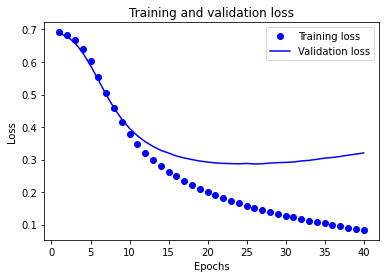

In [68]:
# 훈련 손실, 검증 손실 graph --> 에포크마다 감소함
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo': 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b: 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

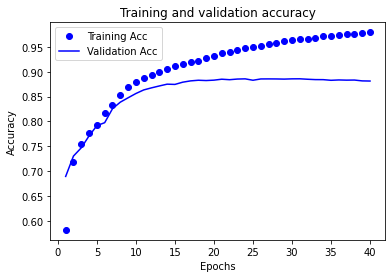

In [69]:
# 훈련, 검증 정확도 graph --> 에포크마다 증가함
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()